In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time

# Record start time
start_time = time.time()

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from PIL import Image
from tensorflow.keras.optimizers import Adam

In [ ]:
data_dir = '/content/drive/MyDrive/GTSRM'
train_path = '/content/drive/MyDrive/GTSRM/Train'
test_path = '/content/drive/MyDrive/GTSRM/Test'
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [ ]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

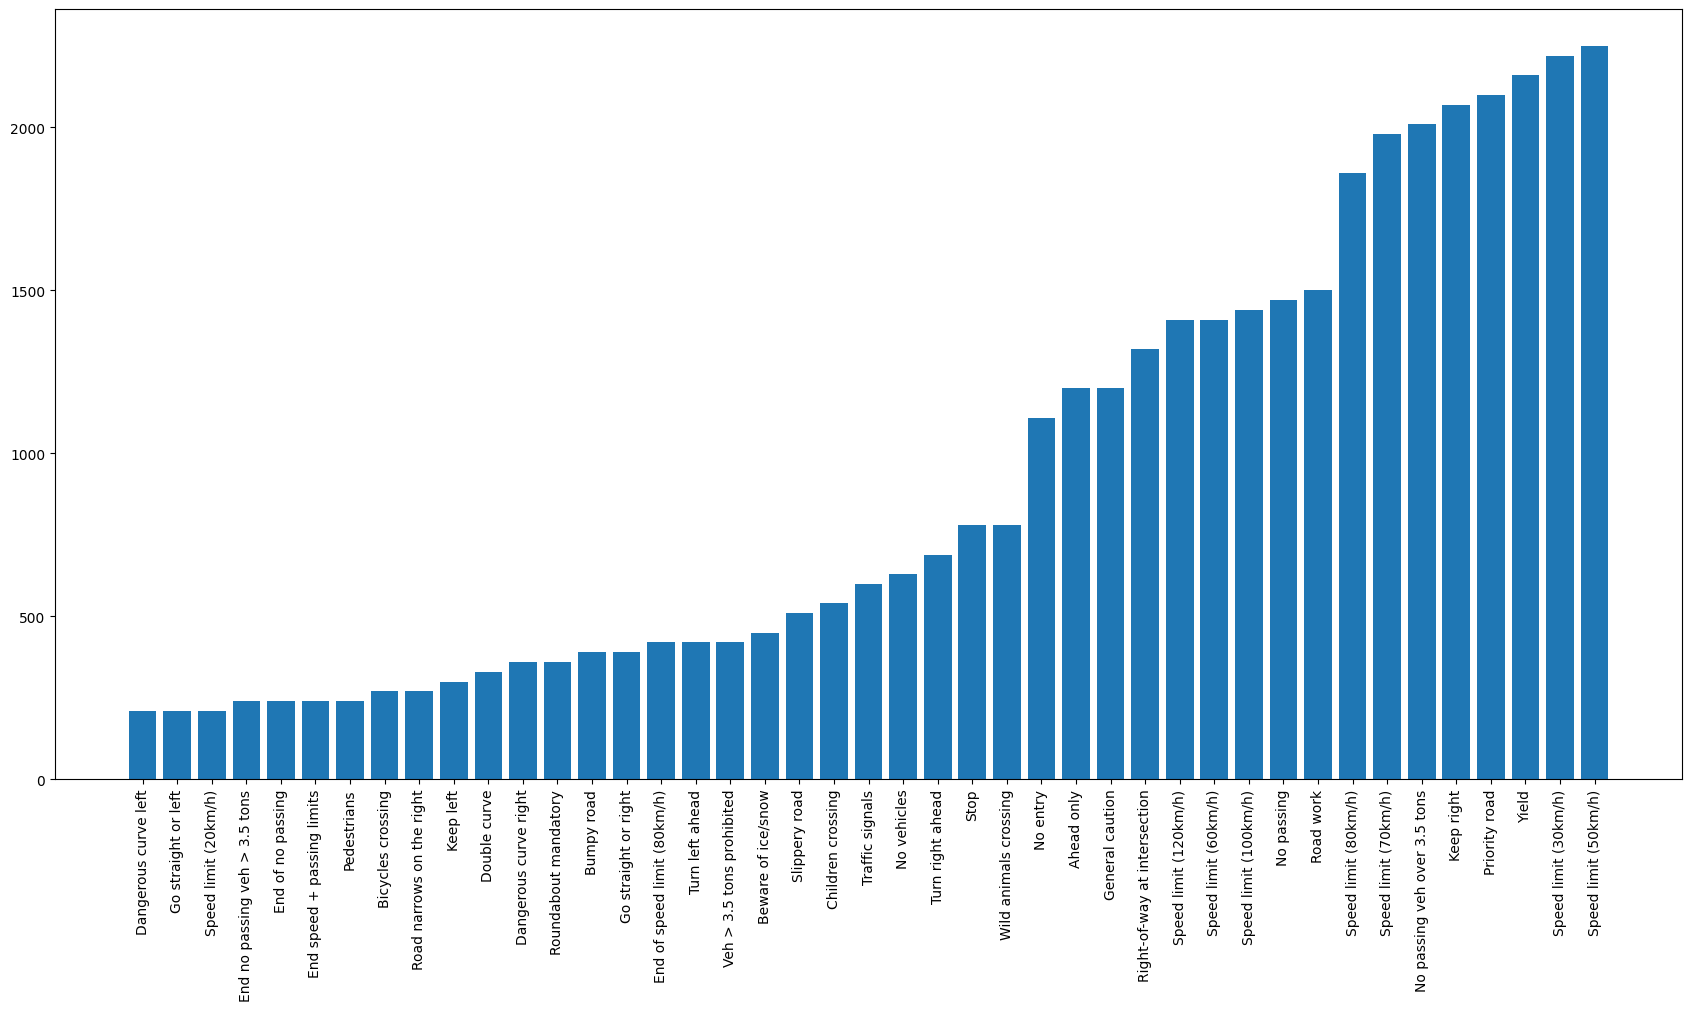

In [ ]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

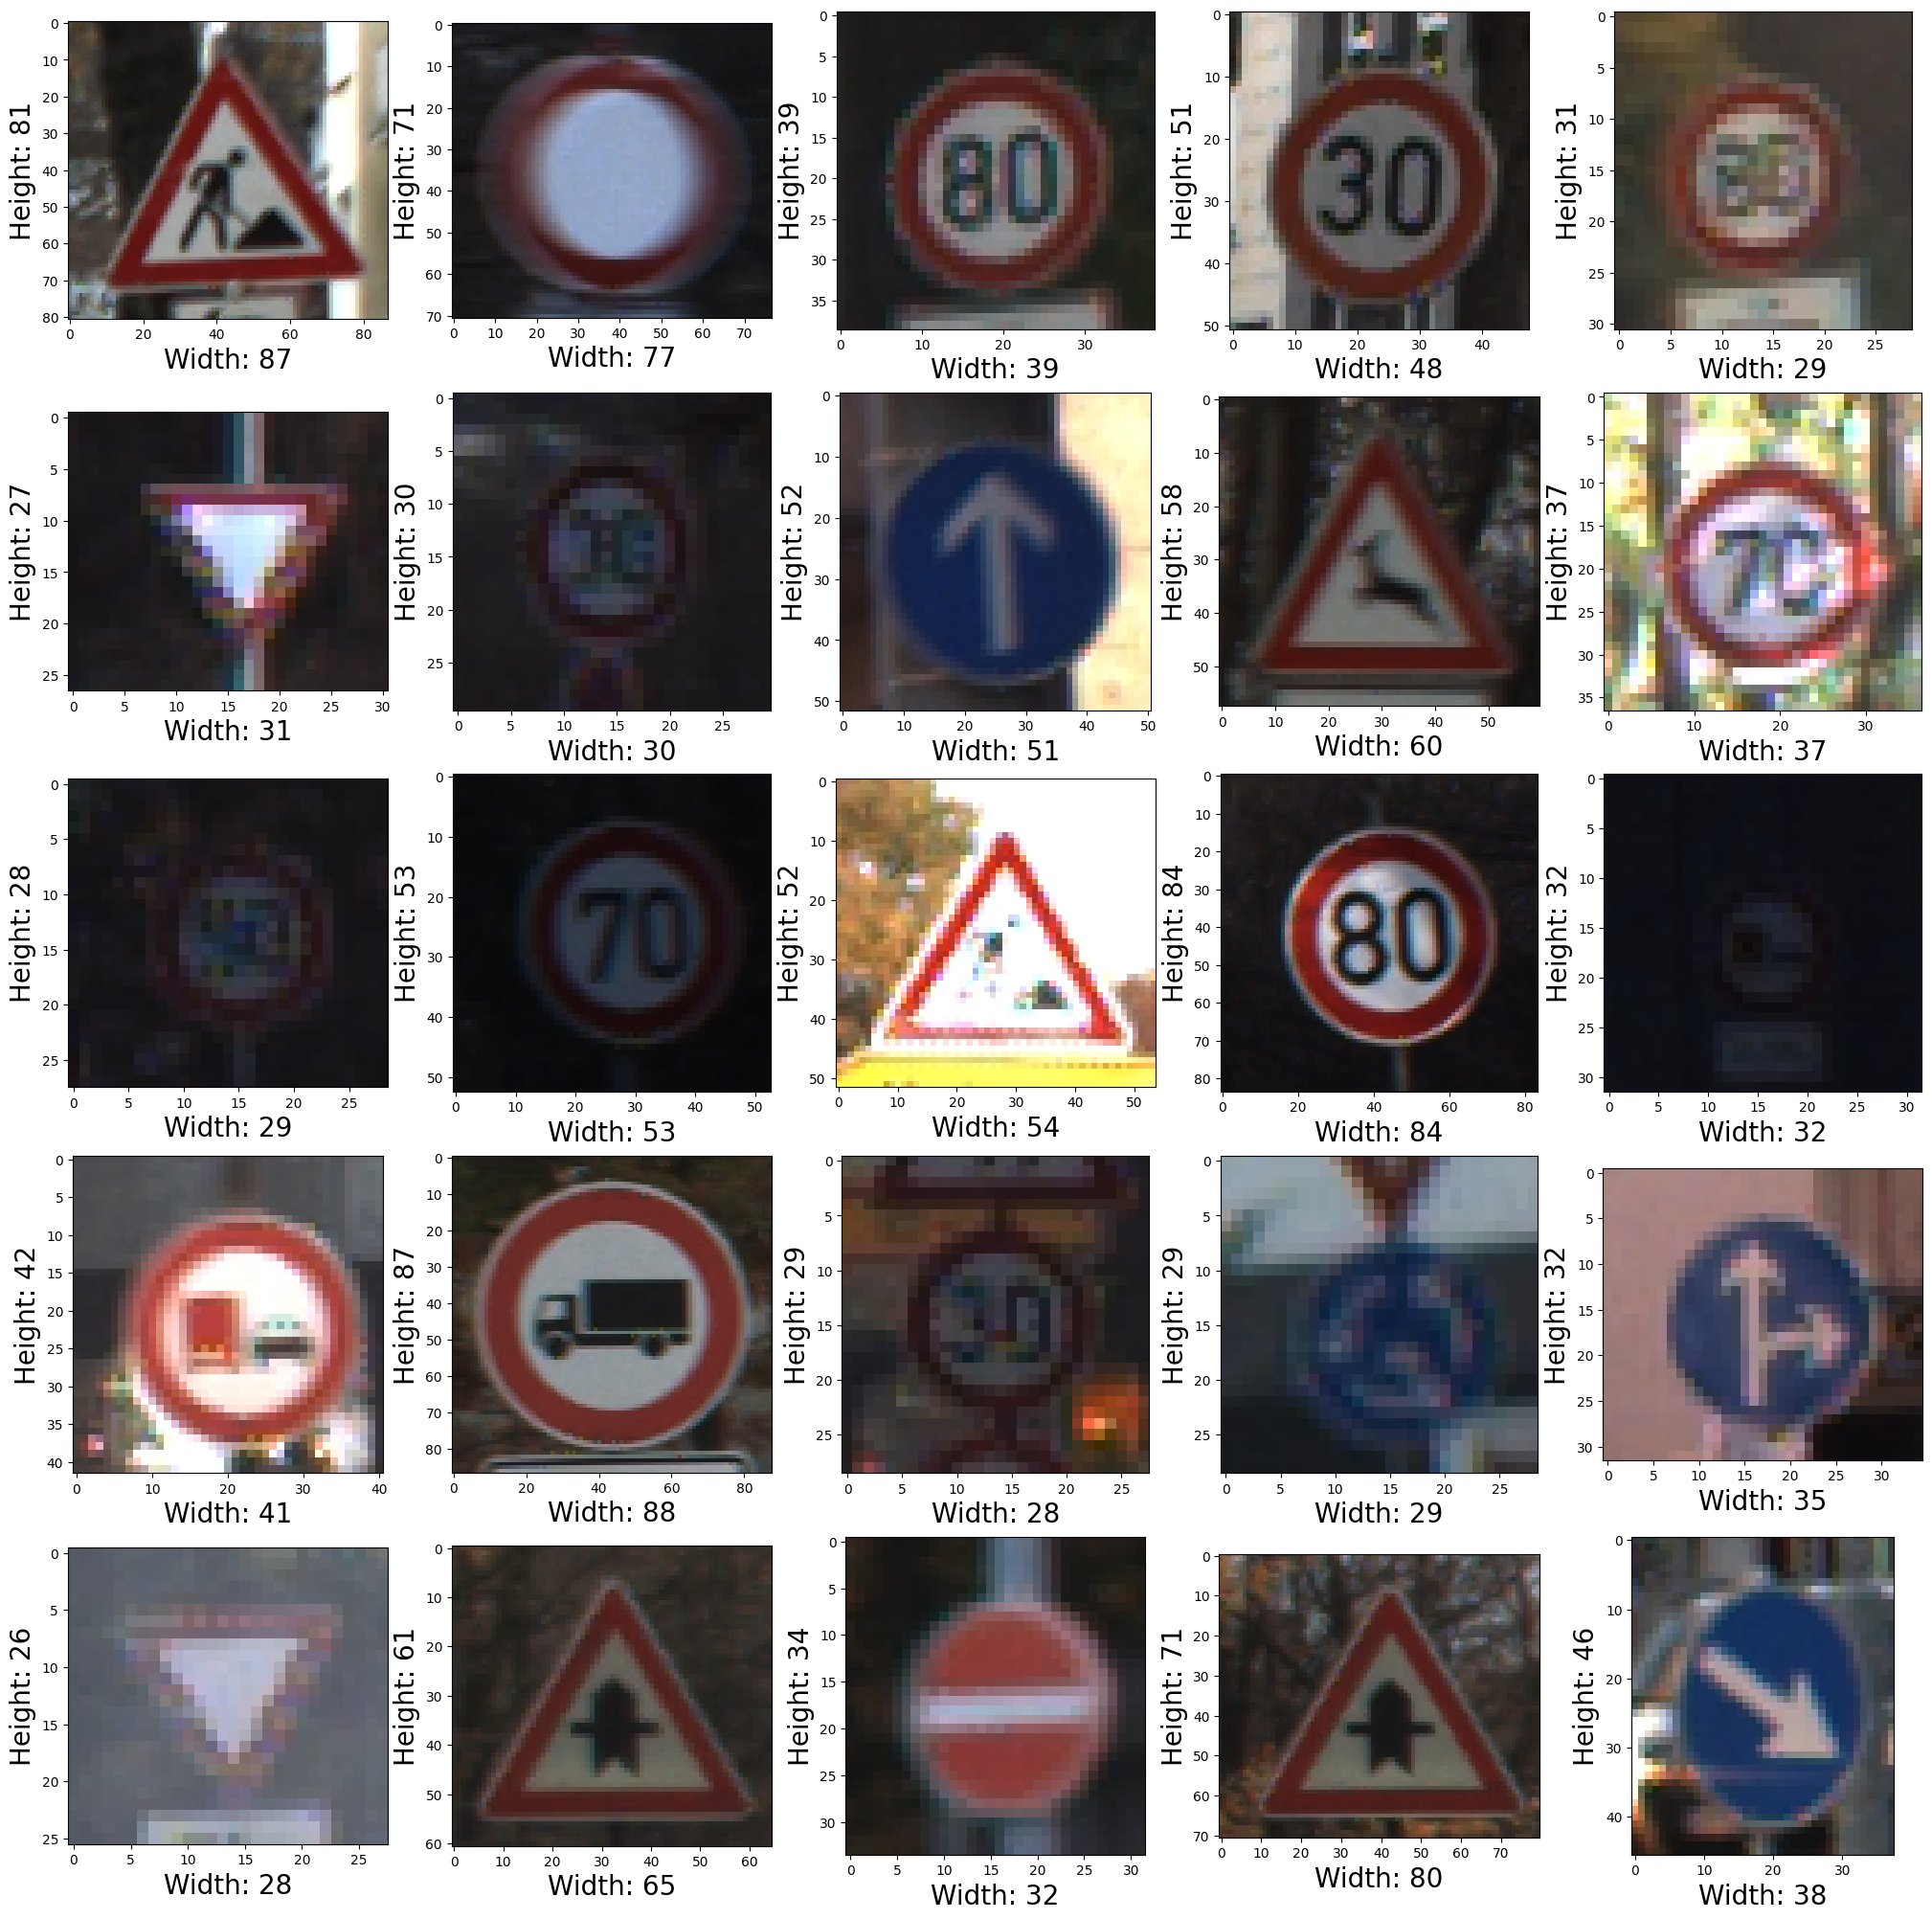

In [ ]:
import random
from matplotlib.image import imread
test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values
plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)

    # Randomly choose an image path
    random_img_path = np.random.choice(imgs)

    # Construct the full path using os.path.join
    random_img_path = os.path.join(data_dir, random_img_path)

    # Attempt to read the image
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(visible=False)
    plt.xlabel("Width: {}".format(rand_img.shape[1]), fontsize=20)
    plt.ylabel("Height: {}".format(rand_img.shape[0]), fontsize=20)

plt.show()

In [ ]:
# def preprocess_image(img_path):
#     img = cv2.imread(img_path)
#     img = cv2.resize(img, (30, 30))  # Resize to ensure consistent dimensions

#     # Apply Gaussian blur
#     img = cv2.GaussianBlur(img, (5, 5), 0)

#     # Convert to HSV
#     hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#     # Binarize image
#     _, binary_img = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 128, 255, cv2.THRESH_BINARY)

#     # Morphological operations
#     kernel = np.ones((3, 3), np.uint8)
#     closed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)
#     eroded_img = cv2.erode(closed_img, kernel, iterations=1)
#     dilated_img = cv2.dilate(eroded_img, kernel, iterations=1)

#     # Find contours and apply ROI extraction
#     contours, _ = cv2.findContours(dilated_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     for contour in contours:
#         x, y, w, h = cv2.boundingRect(contour)
#         aspect_ratio = float(w) / h
#         if 0.8 < aspect_ratio < 1.2:
#             roi = img[y:y+h, x:x+w]
#             roi = cv2.resize(roi, (30, 30))  # Ensure ROI is resized to 30x30
#             break

#     # Use resized ROI or original resized image
#     processed_img = roi if 'roi' in locals() else img

#     # Ensure the image is in correct format
#     processed_img = cv2.resize(processed_img, (30, 30))
#     print(f"Processed image shape: {processed_img.shape}")  # Debug statement
#     return img_to_array(processed_img)

In [ ]:
def preprocess_image(img):
    img = cv2.resize(img, (30, 30))  # Resize to 30x30 for consistency

    # Apply Gaussian blur
    img_blur = cv2.GaussianBlur(img, (5, 5), 0)

    # Convert to HSV
    hsv_img = cv2.cvtColor(img_blur, cv2.COLOR_BGR2HSV)

    # Convert to grayscale and apply binarization
    gray_img = cv2.cvtColor(img_blur, cv2.COLOR_BGR2GRAY)
    _, binary_img = cv2.threshold(gray_img, 128, 255, cv2.THRESH_BINARY)

    # Perform morphological operations
    kernel = np.ones((3, 3), np.uint8)
    closed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)
    eroded_img = cv2.erode(closed_img, kernel, iterations=1)
    dilated_img = cv2.dilate(eroded_img, kernel, iterations=1)

    # Extract ROI based on contours
    contours, _ = cv2.findContours(dilated_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    roi_found = False
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h
        if 0.8 < aspect_ratio < 1.2:  # Check for square-like regions
            roi = img[y:y+h, x:x+w]
            roi = cv2.resize(roi, (30, 30))  # Ensure ROI is resized to 30x30
            roi_found = True
            break

    processed_img = roi if roi_found else img_blur
    processed_img = cv2.resize(processed_img, (30, 30))

    return {
        "Original": img,
        "Gaussian Blur": img_blur,
        "HSV Conversion": hsv_img,
        "Binarization": binary_img,
        "Morphological Operations": dilated_img,
        "ROI Extraction": processed_img
    }


In [ ]:
def load_images_from_folder(folder_path, num_images_per_class=5):
    class_images = {}

    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            images = []
            for i, image_file in enumerate(os.listdir(class_path)):
                if i >= num_images_per_class:
                    break
                img_path = os.path.join(class_path, image_file)
                img = cv2.imread(img_path)
                if img is not None:
                    processed_img = preprocess_image(img)
                    images.append(processed_img)
            class_images[class_folder] = images

    return class_images


In [ ]:
def visualize_class_images(class_images, class_names, num_images_per_class=5):
    """
    Visualize preprocessed images with each preprocessing step in separate columns
    and each class in rows.

    Args:
    - class_images (dict): Dictionary of class labels and corresponding preprocessed images.
    - class_names (dict): Dictionary of class indices to class names.
    - num_images_per_class (int): Number of images to display per class.
    """
    steps = ["Original", "Gaussian Blur", "HSV Conversion", "Binarization", "Morphological Operations", "ROI Extraction"]
    num_classes = len(class_images)

    num_rows = num_classes
    num_cols = len(steps)

    plt.figure(figsize=(num_cols * 3, num_rows * 3))

    # Display column headings
    for step_index, step in enumerate(steps):
        plt.subplot(num_rows + 1, num_cols, step_index + 1)
        plt.text(0.5, 0.5, step, horizontalalignment='center', verticalalignment='center', fontsize=14, weight='bold')
        plt.axis('off')

    for class_index, (class_label, images_list) in enumerate(class_images.items()):
        for step_index, step in enumerate(steps):
            plt.subplot(num_rows + 1, num_cols, (class_index + 1) * num_cols + step_index + 1)
            if len(images_list) > 0:
                img_to_show = images_list[0][step]  # Show first image per class
                if len(img_to_show.shape) == 2:  # Grayscale images
                    plt.imshow(img_to_show, cmap='gray')
                else:
                    plt.imshow(cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                if step_index == 0:
                    plt.title(class_names[int(class_label)], fontsize=10)
            else:
                plt.axis('off')

    plt.tight_layout()
    plt.show()


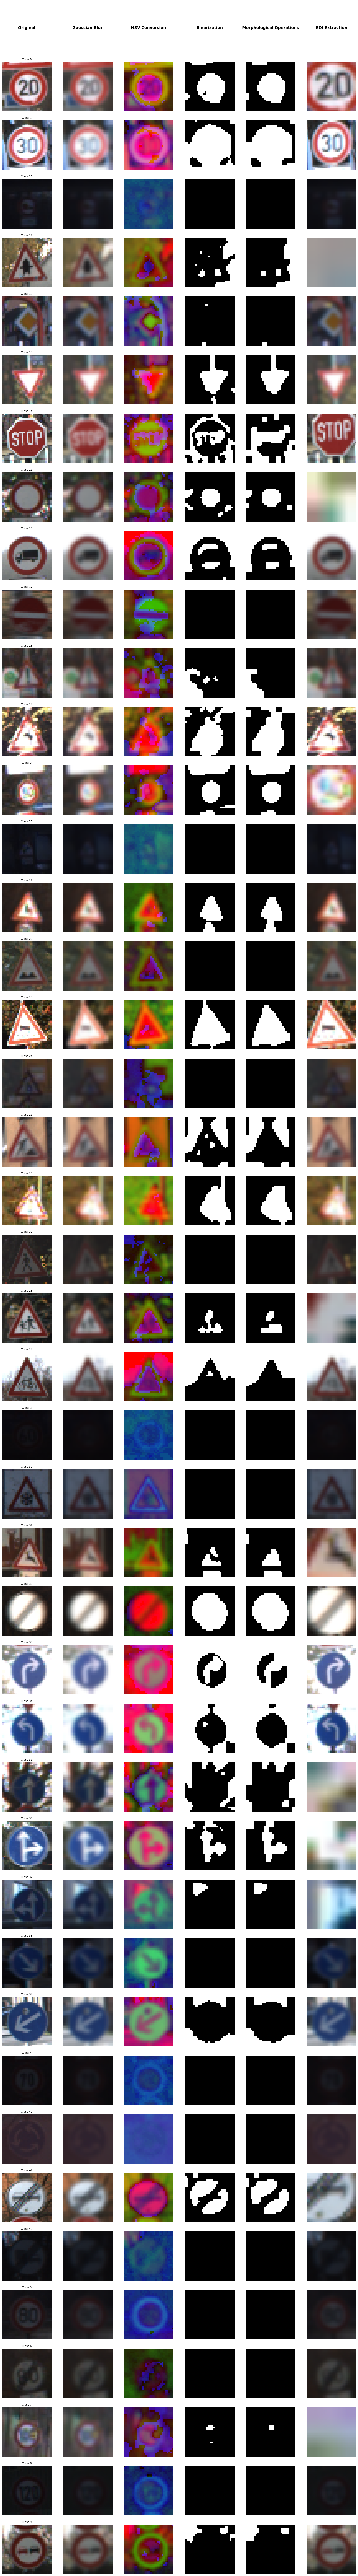

In [ ]:
dataset_folder = '/content/drive/MyDrive/GTSRM/Train'  # Change this to your dataset path
class_images = load_images_from_folder(dataset_folder, num_images_per_class=1)
class_names = {i: f"Class {i}" for i in range(43)}  # Replace with actual class names

# Visualize preprocessing steps
visualize_class_images(class_images, class_names, num_images_per_class=1)

In [ ]:
# Assuming 'images' should contain a list of image data
images = []

for idx, img in enumerate(images):
    if img.shape != (30, 30, 3):
        print(f"Image at index {idx} has shape {img.shape}")


In [ ]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (30, 30))

    # Proceed with additional preprocessing...
    # Ensure image shape is consistent
    processed_img = img
    processed_img = cv2.resize(processed_img, (30, 30))

    return img_to_array(processed_img)


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_data(data_dir):
    images = []
    labels = []
    for category in range(NUM_CATEGORIES):
        categories = os.path.join(data_dir, str(category))
        for img_file in os.listdir(categories):
            img_path = os.path.join(categories, img_file)
            img = load_img(img_path, target_size=(30, 30))  # Ensure consistent size
            image = img_to_array(img)
            images.append(image)
            labels.append(category)

    return images, labels


In [ ]:
images, labels = load_data(train_path)

In [ ]:
IMG_SIZE = 30
NUM_CLASSES = 43
imgs_path = '/content/drive/MyDrive/GTSRM/Train'

# Load and preprocess data
processed_images = []
processed_labels = []

# Iterate through each class directory
for label in range(NUM_CLASSES):
    class_path = os.path.join(imgs_path, str(label))  # Path to class folder
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        # Open the image using PIL
        img = Image.open(img_path)

        # Resize image to (30, 30)
        img_resized = img.resize((IMG_SIZE, IMG_SIZE))
        img_array = np.array(img_resized)

        # Ensure image has 3 channels (RGB)
        if img_array.shape != (IMG_SIZE, IMG_SIZE, 3):
            img_array = np.stack([img_array] * 3, axis=-1)  # Convert grayscale to RGB

        # Append to list
        processed_images.append(img_array)
        processed_labels.append(label)

# Convert lists to numpy arrays
processed_images = np.array(processed_images)
processed_labels = np.array(processed_labels)

# Normalize image data
processed_images = processed_images / 255.0

# Convert labels to one-hot encoded format
processed_labels = to_categorical(processed_labels, num_classes=NUM_CLASSES)


In [ ]:
# Print shapes for verification
print(f"Data shape: {processed_images.shape}")  # (num_samples, 30, 30, 3)
print(f"Labels shape: {processed_labels.shape}")  # (num_samples, 43)

Data shape: (39209, 30, 30, 3)
Labels shape: (39209, 43)


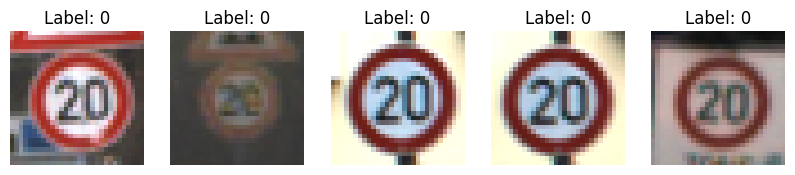

In [ ]:
def visualize_samples(images, labels, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.show()

# Visualize 5 sample images
visualize_samples(processed_images, processed_labels, num_samples=5)

Image 0 is preprocessed correctly.


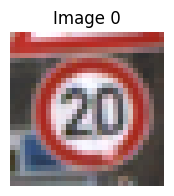

Image 1 is preprocessed correctly.


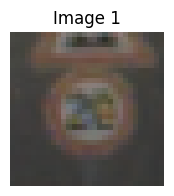

Image 2 is preprocessed correctly.


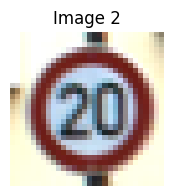

Image 3 is preprocessed correctly.


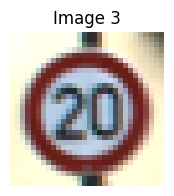

Image 4 is preprocessed correctly.


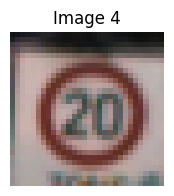

Streaming output truncated to the last 5000 lines.
Image 34210 is preprocessed correctly.
Image 34211 is preprocessed correctly.
Image 34212 is preprocessed correctly.
Image 34213 is preprocessed correctly.
Image 34214 is preprocessed correctly.
Image 34215 is preprocessed correctly.
Image 34216 is preprocessed correctly.
Image 34217 is preprocessed correctly.
Image 34218 is preprocessed correctly.
Image 34219 is preprocessed correctly.
Image 34220 is preprocessed correctly.
Image 34221 is preprocessed correctly.
Image 34222 is preprocessed correctly.
Image 34223 is preprocessed correctly.
Image 34224 is preprocessed correctly.
Image 34225 is preprocessed correctly.
Image 34226 is preprocessed correctly.
Image 34227 is preprocessed correctly.
Image 34228 is preprocessed correctly.
Image 34229 is preprocessed correctly.
Image 34230 is preprocessed correctly.
Image 34231 is preprocessed correctly.
Image 34232 is preprocessed correctly.
Image 34233 is preprocessed correctly.
Image 34234 i

In [ ]:
def check_preprocessing(images, target_shape=(30, 30, 3), min_value=0.0, max_value=1.0, display_samples=5):
    """
    Check if all images are preprocessed correctly and display a few samples.

    Args:
    - images (numpy array): Array of preprocessed images.
    - target_shape (tuple): Expected shape of each image.
    - min_value (float): Minimum expected value of pixel intensity.
    - max_value (float): Maximum expected value of pixel intensity.
    - display_samples (int): Number of preprocessed images to display.

    Returns:
    - None
    """
    all_preprocessed = True

    for idx, img in enumerate(images):
        if img.shape != target_shape:
            print(f"Image {idx} has incorrect shape: {img.shape}")
            all_preprocessed = False
        elif img.min() < min_value or img.max() > max_value:
            print(f"Image {idx} has pixel values out of range: min={img.min()}, max={img.max()}")
            all_preprocessed = False
        else:
            print(f"Image {idx} is preprocessed correctly.")

        # Display the first few images
        if idx < display_samples:
            plt.figure(figsize=(2, 2))
            plt.imshow(img)
            plt.title(f"Image {idx}")
            plt.axis('off')
            plt.show()

    if all_preprocessed:
        print("All images are preprocessed correctly!")
    else:
        print("Some images are not preprocessed correctly.")

# Assuming `processed_images` contains your preprocessed images
check_preprocessing(processed_images)


In [ ]:
# Global flag to indicate if normalization has been performed
normalization_done = False

def check_normalization(data):
    """
    Check if the data has been normalized.

    Args:
    - data (numpy array): Array of images to check.

    Returns:
    - (bool, float, float):
      - is_normalized (bool): True if data is normalized (in range [0, 1]), False otherwise.
      - min_value (float): Minimum value in the data.
      - max_value (float): Maximum value in the data.
    """
    min_value = np.min(data)
    max_value = np.max(data)

    # Check if the range is between 0 and 1
    is_normalized = (min_value >= 0 and max_value <= 1)

    # Print appropriate message
    if is_normalized:
        global normalization_done
        if not normalization_done:
            print("Data is properly normalized.")
            normalization_done = True
        else:
            print("Normalization has already been done.")
    else:
        print("Data is not normalized properly.")

    return is_normalized, min_value, max_value
# Check normalization status
is_normalized, min_value, max_value = check_normalization(processed_images)
print(f"Min value: {min_value}")
print(f"Max value: {max_value}")

Data is properly normalized.
Min value: 0.0
Max value: 1.0


In [ ]:
# Print shapes for verification
print(f"Data shape: {processed_images.shape}")  # (num_samples, 30, 30, 3)
print(f"Labels shape: {processed_labels.shape}")  # (num_samples, 43)

# Print summary statistics of the data
print(f"Data type: {processed_images.dtype}")
print(f"Min pixel value: {np.min(processed_images)}")
print(f"Max pixel value: {np.max(processed_images)}")
print(f"Mean pixel value: {np.mean(processed_images)}")
print(f"Std deviation of pixel values: {np.std(processed_images)}")

# Print a summary of the first image
print(f"First image shape: {processed_images[0].shape}")
print(f"First image pixel value range: {np.min(processed_images[0])} to {np.max(processed_images[0])}")

# Print detailed information for a few sample images
for i in range(min(3, len(processed_images))):  # Print data for up to 3 images
    print(f"Sample image {i} shape: {processed_images[i].shape}")
    print(f"Sample image {i} pixel value range: {np.min(processed_images[i])} to {np.max(processed_images[i])}")
    print(f"Sample image {i} mean pixel value: {np.mean(processed_images[i])}")
    print(f"Sample image {i} std deviation of pixel values: {np.std(processed_images[i])}")
    print(f"Sample image {i} sample pixel values (flattened): {processed_images[i].flatten()[:100]}...")  # Print first 100 values

Data shape: (39209, 30, 30, 3)
Labels shape: (39209, 43)
Data type: float64
Min pixel value: 0.0
Max pixel value: 1.0
Mean pixel value: 0.3243561532796901
Std deviation of pixel values: 0.2701288891580375
First image shape: (30, 30, 3)
First image pixel value range: 0.08235294117647059 to 1.0
Sample image 0 shape: (30, 30, 3)
Sample image 0 pixel value range: 0.08235294117647059 to 1.0
Sample image 0 mean pixel value: 0.45876397966594046
Sample image 0 std deviation of pixel values: 0.23713009648110864
Sample image 0 sample pixel values (flattened): [0.74509804 0.57254902 0.53333333 0.76470588 0.30588235 0.2627451
 0.7372549  0.17647059 0.14509804 0.75686275 0.3254902  0.32156863
 0.97647059 0.82745098 0.90196078 1.         0.98431373 1.
 1.         0.99607843 1.         1.         0.98431373 1.
 1.         0.95686275 0.98823529 1.         0.92941176 0.96862745
 0.98431373 0.84313725 0.8627451  0.89803922 0.77254902 0.77254902
 0.92156863 0.81176471 0.87843137 0.92156863 0.80392157 0.8

In [ ]:
# Split the data into training and testing sets (70% train, 30% test)
x_train, x_test, y_train, y_test = train_test_split(processed_images, processed_labels, test_size=0.3, random_state=42, shuffle=True)

# Verify the shapes of the resulting arrays
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (27446, 30, 30, 3)
x_test shape: (11763, 30, 30, 3)
y_train shape: (27446, 43)
y_test shape: (11763, 43)


In [ ]:
# Function to prepare the dataset (normalization and one-hot encoding)
def prep_dataset(X, y, num_classes=43):
    X_prep = X.astype('float32') / 255.0  # Normalize image data
    y_prep = to_categorical(np.array(y), num_classes=num_classes)  # One-hot encoding for labels
    return X_prep, y_prep

# Apply the prep_dataset function on the training and test data
x_train_prep, y_train_prep = prep_dataset(x_train, y_train)
x_test_prep, y_test_prep = prep_dataset(x_test, y_test)

# Verify the shapes of the processed arrays
print(f"x_train_prep shape: {x_train_prep.shape}")
print(f"y_train_prep shape: {y_train_prep.shape}")
print(f"x_test_prep shape: {x_test_prep.shape}")
print(f"y_test_prep shape: {y_test_prep.shape}")

x_train_prep shape: (27446, 30, 30, 3)
y_train_prep shape: (27446, 43, 43)
x_test_prep shape: (11763, 30, 30, 3)
y_test_prep shape: (11763, 43, 43)


In [ ]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3), activation="relu", input_shape=(30, 30, 3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation="softmax"))  # Output layer with 43 classes

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# print(f"x_train_prep shape: {x_train_prep.shape}")  # Should be (num_samples, 30, 30, 3)
# print(f"y_train_prep shape: {y_train_prep.shape}")  # Should be (num_samples, 43)

# print(f"x_test_prep shape: {x_test_prep.shape}")  # Should be (num_samples, 30, 30, 3)
# print(f"y_test_prep shape: {y_test_prep.shape}")  # Should be (num_samples, 43)

x_train_prep shape: (27446, 30, 30, 3)
y_train_prep shape: (27446, 43, 43)
x_test_prep shape: (11763, 30, 30, 3)
y_test_prep shape: (11763, 43, 43)


In [ ]:
# Assuming 'processed_images' and 'processed_labels' hold your data
X = processed_images
y = processed_labels
X_train, X_val, Y_train, Y_val = train_test_split(X,y, test_size=0.2, shuffle=True,stratify=np.argmax(y, axis=1)) # Use argmax to get 1D array of class labels
X_val, X_test, Y_val, Y_test = train_test_split(X_val,Y_val, test_size=0.5, shuffle=True)

# Check if labels are already one-hot encoded
if len(Y_train.shape) == 1:  # If Y_train is 1D, apply to_categorical
    from tensorflow.keras.utils import to_categorical
    Y_train = to_categorical(Y_train, num_classes=43)
    Y_val = to_categorical(Y_val, num_classes=43)
    Y_test = to_categorical(Y_test, num_classes=43)  # Assuming you will use Y_test later
elif len(Y_train.shape) == 2:
    print("Labels are already one-hot encoded.")
else:
    print("Unexpected label shape. Please check your data.")

print(f"Y_train shape: {Y_train.shape}")  # Verify the shape

Labels are already one-hot encoded.
Y_train shape: (31367, 43)


In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model
history = model.fit(
    X_train,
    Y_train,
    epochs=15,
    batch_size=64,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)


Epoch 1/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.3972 - loss: 2.2094 - val_accuracy: 0.9597 - val_loss: 0.1509
Epoch 2/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9274 - loss: 0.2384 - val_accuracy: 0.9872 - val_loss: 0.0508
Epoch 3/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9666 - loss: 0.1094 - val_accuracy: 0.9901 - val_loss: 0.0341
Epoch 4/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9760 - loss: 0.0773 - val_accuracy: 0.9952 - val_loss: 0.0200
Epoch 5/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9795 - loss: 0.0669 - val_accuracy: 0.9959 - val_loss: 0.0221
Epoch 6/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9860 - loss: 0.0453 - val_accuracy: 0.9967 - val_loss: 0.0165
Epoch 7/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9862 - loss: 0.0401 - val_accuracy: 0.9964 - val_loss: 0.0156
Epoch 8/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9882 - loss: 0.0392 - val_accuracy: 

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9974 - loss: 0.0067
Test Loss: 0.01020131167024374
Test Accuracy: 0.9969395399093628


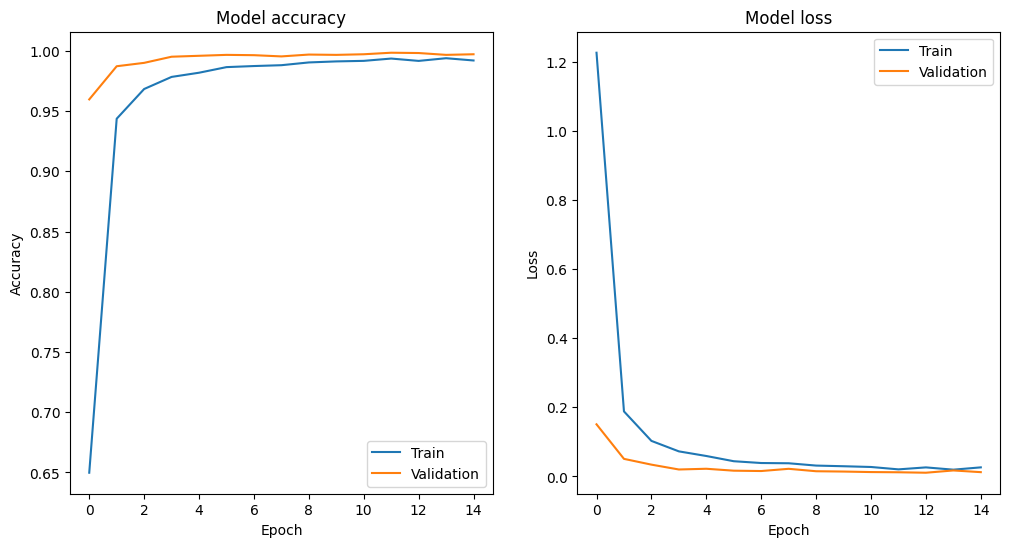

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()


In [ ]:
# Record end time
end_time = time.time()

# Calculate and print total execution time
execution_time = end_time - start_time
print(f"Total execution time: {execution_time:.2f} seconds")


Total execution time: 1752.77 seconds


In [ ]:
# Convert to hours, minutes, and seconds
hours, rem = divmod(execution_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Total execution time: {int(hours):02}:{int(minutes):02}:{seconds:.2f} (hh:mm:ss)")


Total execution time: 00:29:12.77 (hh:mm:ss)


In [ ]:
from tensorflow.keras.models import load_model

# Define the path where the model will be saved
model_save_path = '/content/drive/MyDrive/GTSRM/traffic_sign_model.h5'

# Save the model
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /content/drive/MyDrive/GTSRM/traffic_sign_model.h5


In [ ]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import accuracy_score

# Define the path
test_path = '/content/drive/MyDrive/GTSRM'
csv_file = 'Test.csv'
full_path = os.path.join(test_path, csv_file)

# Load test data
try:
    Y_test = pd.read_csv(full_path)
    test_labels = Y_test["ClassId"].values
    test_images = Y_test["Path"].values
except FileNotFoundError:
    print(f"File not found: {full_path}")
    raise

# Load and preprocess test images
output = []
for img in test_images:
    img_path = os.path.join(test_path, img)
    if os.path.exists(img_path):
        image = load_img(img_path, target_size=(30, 30))
        image = img_to_array(image) / 255.0  # Normalize images
        output.append(image)
    else:
        print(f"Image file not found: {img_path}")

X_test = np.array(output)

# Predict on test images
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)  # Convert probabilities to class labels

# Calculate accuracy
print('Test Data Accuracy: ', accuracy_score(test_labels, pred) * 100)


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Test Data Accuracy:  96.05700712589073


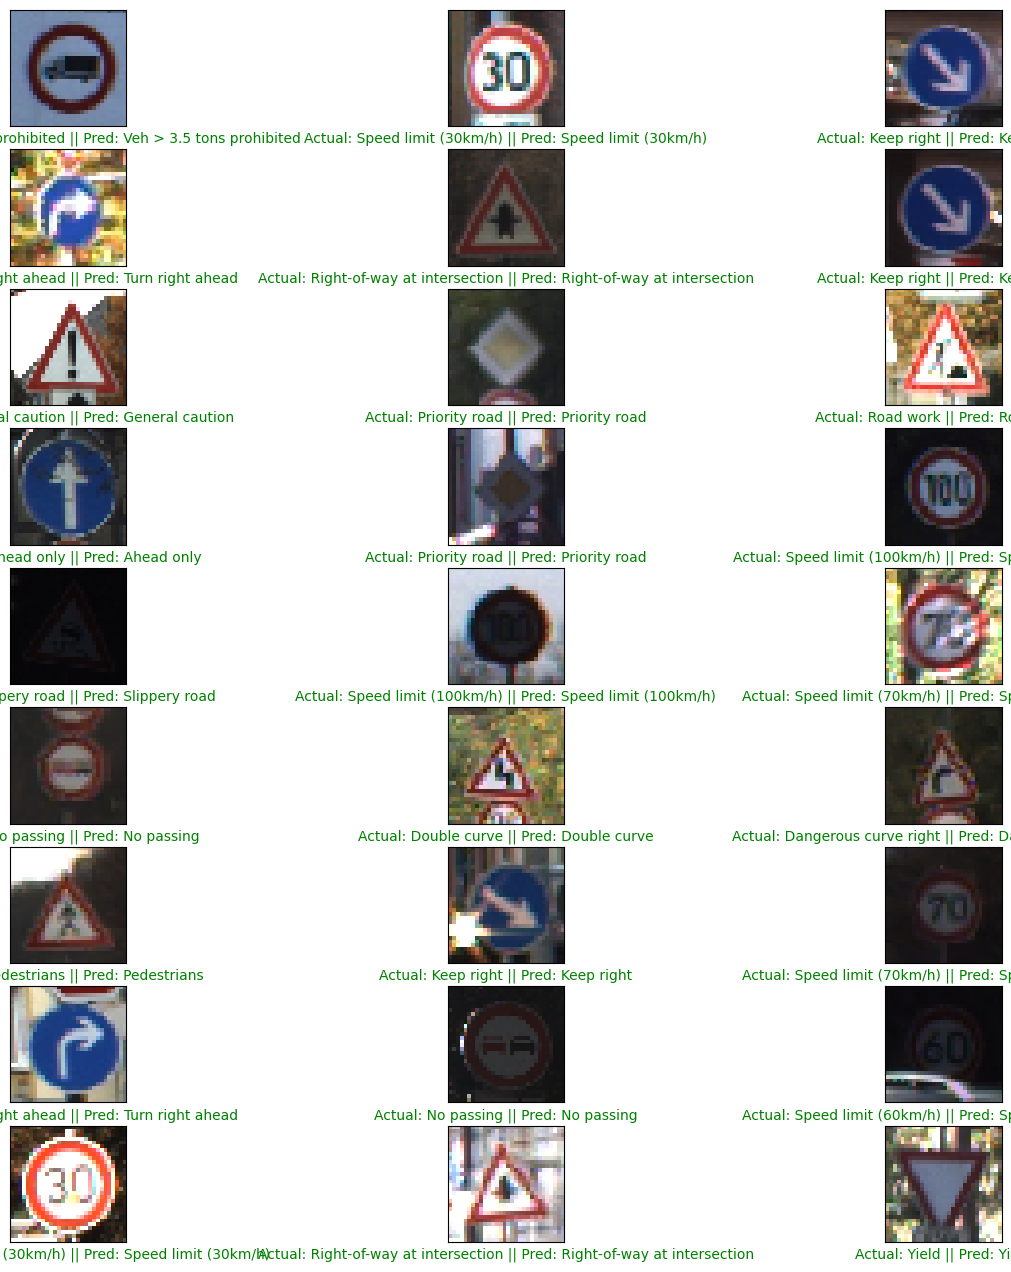

In [ ]:
# Plot configuration
plt.figure(figsize=(16, 16))

start_index = 0
num_images = min(len(X_test), 27)  # Ensure you do not exceed the number of test images

rows = num_images // 3  # Calculate the number of rows needed
for i in range(num_images):
    plt.subplot(rows, 3, i + 1)  # Set up a 3-images per row layout
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Get prediction and actual label
    prediction = pred[start_index + i]
    actual = test_labels[start_index + i]

    # Determine color based on correctness
    col = 'g' if prediction == actual else 'r'

    # Display the image and add labels
    plt.xlabel(f'Actual: {classes[actual]} || Pred: {classes[prediction]}', color=col)
    plt.imshow(X_test[start_index + i])

plt.show()


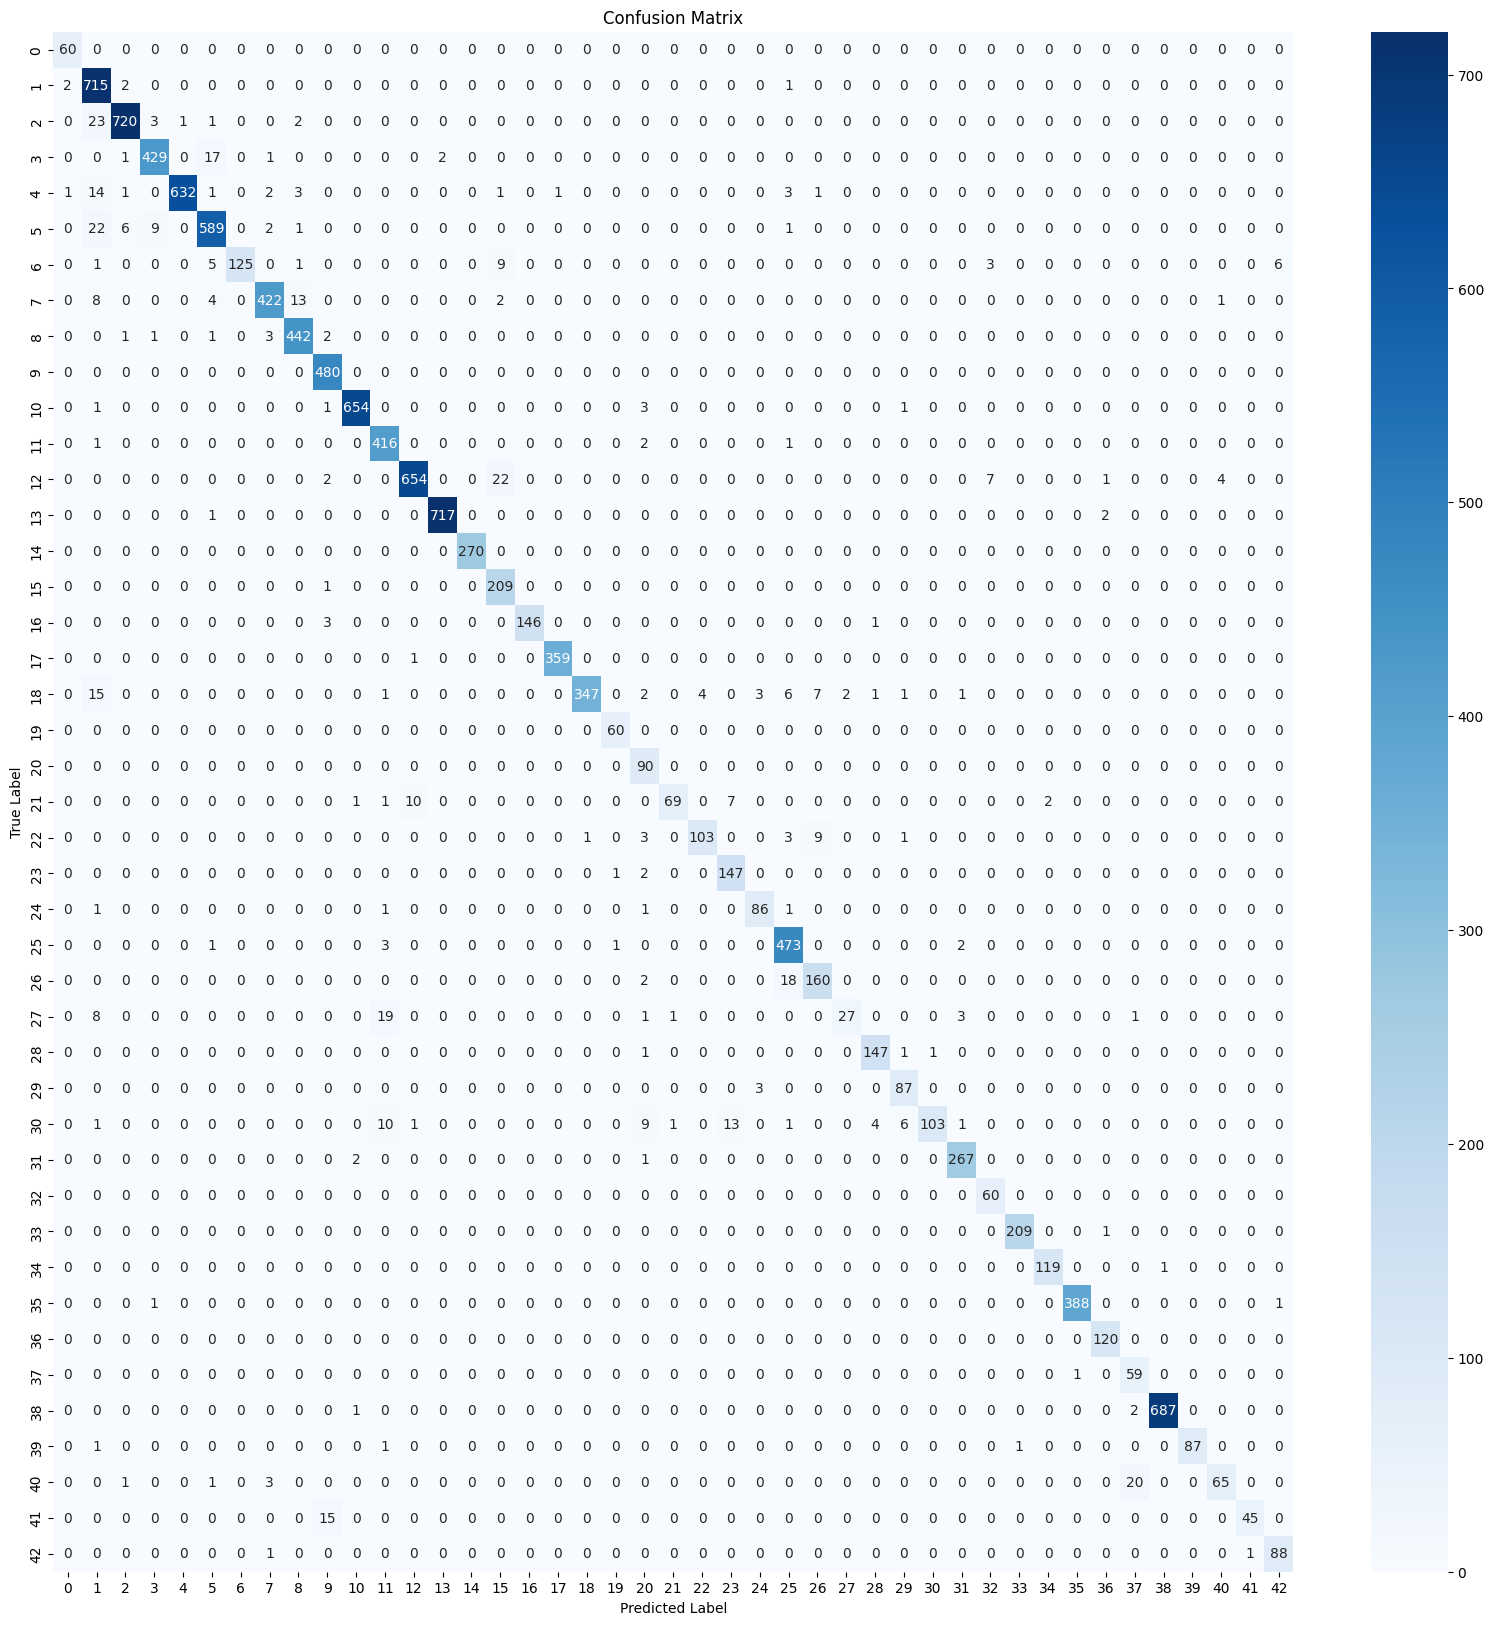

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cf = confusion_matrix(test_labels, pred)

# Ensure classes are sorted consistently with confusion matrix labels
classes_sorted = sorted(classes.keys())

# Create a DataFrame for the confusion matrix
df_cm = pd.DataFrame(cf, index=[classes[i] for i in classes_sorted], columns=[classes[i] for i in classes_sorted])

# Plot the confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes_sorted, yticklabels=classes_sorted)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
